In [63]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from shapely import wkt
import json

# TODO will we predict just the edifc_uso or also edifc_stat & edifc_ty?
# TODO get the dictionary w/ definitions for edifc_uso

In [64]:
# Load dataset
dataset = pd.read_csv("data/postgis_output/D45420917_0101_Punti.csv", dtype={'edifc_uso': object}) # TODO read whole dataset properly
dataset['points_geometry'] = dataset.points_geometry.apply(wkt.loads)
dataset['footprint_geometry'] = dataset.footprint_geometry.apply(wkt.loads)

# Convert geometries into pixels (?) # TODO better description
dataset["points"] = [[(point.x, point.y, point.z) for point in multipoint.geoms] for multipoint in list(dataset["points_geometry"])]

with open("edifc_uso_general.json", "r") as f:
    edifc_uso_mapping = json.load(f)
dataset["edifc_uso_desc"] = dataset["edifc_uso"].map(edifc_uso_mapping)

In [65]:
from scipy.interpolate import LinearNDInterpolator
import requests
import math
import matplotlib.image as mpimg
from matplotlib import rcParams

def plot_points(x, y, z, ax):
        X = np.linspace(min(x), max(x), num=200)
        Y = np.linspace(min(y), max(y), num=200)
        X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
        interp = LinearNDInterpolator(list(zip(x, y)), z)
        Z = interp(X, Y)
        ax.pcolormesh(X, Y, Z, shading='auto', cmap="viridis")
        ax.legend()
        ax.axis("equal")
        ax.plot(np.median(x), np.median(y), color='red', marker='o', markersize=20)

def plot_footprint(footprint, ax):
        for poly in footprint.geoms:
                ax.plot(*poly.exterior.xy, color="red", linewidth=3)


def show_satellite_image(x, y, ax, zoom = 19):
        # Mapbox access token
        access_token = 'pk.eyJ1IjoibWF0dGVvYmlnbGlvbGkiLCJhIjoiY2txcGN0cmJ5MDBqdTJvazV6cXdiM2ZqOSJ9.Bd6Gd05464fMSOpqCB-uTw'

        # Define the Mapbox API endpoint for creating a static map
        center_x = np.median(x)
        center_y = np.median(y)
        url = f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/pin-l+f41010({center_x},{center_y})/{center_x},{center_y},18.55,0/512x512@2x?access_token={access_token}"
        # Send the API request and get the image
        with open("satellite_image.jpeg", 'wb') as f:
                f.write(requests.get(url).content)

        satellite_image = mpimg.imread('satellite_image.jpeg', format="jpeg")
        ax.imshow(satellite_image)

def show_dataset_sample(footprint, points):
        x, y, z = map(np.array, zip(*points))
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 8))

        plot_points(x, y, z, ax[0])
        plot_footprint(footprint, ax[0])
        show_satellite_image(x, y, ax[1])

        plt.draw()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


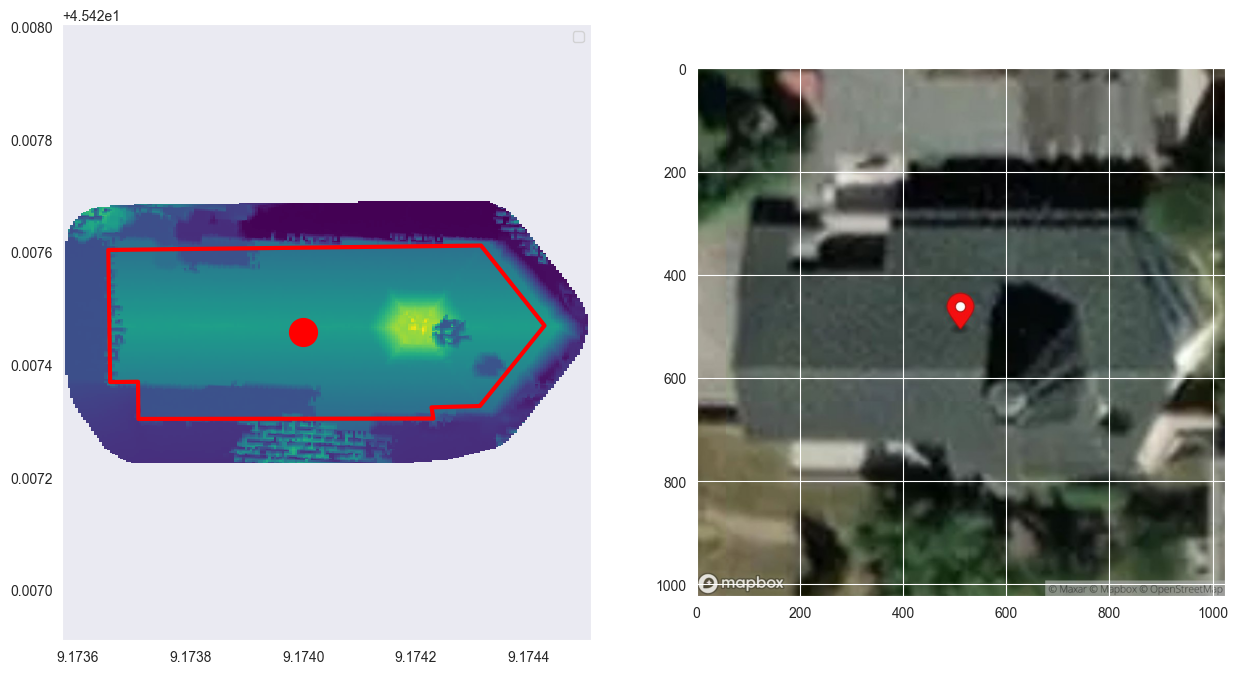

In [66]:
# Show dataset example
example_n = 22
points = dataset.iloc[example_n,-2]
footprint = list(dataset["footprint_geometry"])[example_n]
show_dataset_sample(footprint, points)

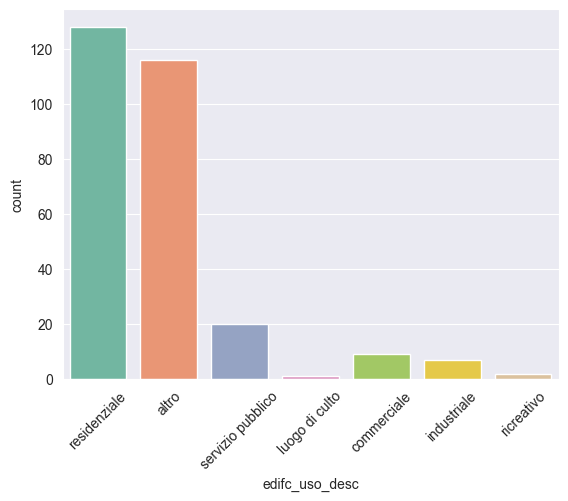

In [67]:
# Check if dataset is balanced
sn.set_style('darkgrid')
sn.countplot(x = "edifc_uso_desc", data = dataset, palette="Set2") 
plt.xticks(rotation=45)
plt.show()

In [68]:
dataset

,footprint_id,edifc_stat,edifc_ty,edifc_uso,max_in_footprint,percentile_20,percentile_40,percentile_60,percentile_80,min_overrall,building_height,roof_height,footprint_area,footprint_geometry,points_geometry,points,edifc_uso_desc
0,140.0,3,1,01,170.99,164.440,164.648,164.930,165.216,151.87,19.12,6.342,76.273160,MULTIPOLYGON (((9.176693648412613 45.428456800...,"MULTIPOINT Z (9.17664976 45.4283659 152.21, 9....","[(9.17664976, 45.4283659, 152.21), (9.1765843,...",residenziale
1,627.0,2,95,95,156.95,151.962,152.156,152.346,152.624,149.12,7.83,4.794,21.651840,MULTIPOLYGON (((9.176002664700748 45.423953035...,"MULTIPOINT Z (9.17599981 45.42391228 155.51, 9...","[(9.17599981, 45.42391228, 155.51), (9.1760488...",altro
2,688.0,2,95,95,155.66,153.146,153.172,153.200,153.230,150.11,5.55,2.488,92.008197,MULTIPOLYGON (((9.17912867778949 45.4225817702...,"MULTIPOINT Z (9.17918852 45.42241194 150.2, 9....","[(9.17918852, 45.42241194, 150.2), (9.17915056...",altro
3,933.0,3,1,01,171.36,162.940,162.980,163.010,163.930,150.45,20.91,8.380,134.917849,MULTIPOLYGON (((9.177087192685937 45.428125934...,"MULTIPOINT Z (9.17699147 45.42816537 163.95, 9...","[(9.17699147, 45.42816537, 163.95), (9.1769818...",residenziale
4,1096.0,3,1,01,166.55,160.612,160.814,161.190,161.548,152.49,14.06,5.736,77.201786,MULTIPOLYGON (((9.176716354400089 45.429724283...,"MULTIPOINT Z (9.17654394 45.429605 152.56, 9.1...","[(9.17654394, 45.429605, 152.56), (9.17653422,...",residenziale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,73695.0,3,1,01,167.77,162.000,162.538,163.160,163.722,149.69,18.08,5.232,144.764157,MULTIPOLYGON (((9.176628192831513 45.422453781...,"MULTIPOINT Z (9.17644474 45.42246509 149.84, 9...","[(9.17644474, 45.42246509, 149.84), (9.1764544...",residenziale
279,73849.0,3,1,01,168.85,163.750,163.918,164.340,164.710,151.86,16.99,4.932,96.081580,MULTIPOLYGON (((9.176749806827988 45.429449777...,"MULTIPOINT Z (9.17659314 45.42943642 153.37, 9...","[(9.17659314, 45.42943642, 153.37), (9.1766220...",residenziale
280,74580.0,2,95,95,167.87,153.650,153.680,153.710,158.318,149.53,18.34,14.190,580.339285,MULTIPOLYGON (((9.178503852576116 45.429185400...,"MULTIPOINT Z (9.17889071 45.42913418 153.64, 9...","[(9.17889071, 45.42913418, 153.64), (9.1789098...",altro
281,74594.0,3,1,01,177.89,160.860,167.020,168.660,170.002,149.54,28.35,10.870,610.056005,MULTIPOLYGON (((9.17649998283213 45.4238395791...,"MULTIPOINT Z (9.17674466 45.42387512 150.13, 9...","[(9.17674466, 45.42387512, 150.13), (9.1767348...",residenziale


In [4]:
# Dataset won't be balanced => make it balanced

In [5]:
# Extract features -> Done in postgis

# TODO Slope on a grid over the footprint
# TODO Numer of relative Max/Min
# TODO Proximity of other footprints





In [6]:
# Classify w/ features

In [7]:
# Classify w/ CNN

In [ ]:
# Results and comparison